In [5]:
import numpy as np
import torch as th

In [24]:
inputs = th.Tensor([[1,0,0],[0,1,0],[0,0,1]])
messages = th.Tensor([[0,0],[1,1],[2,2]])

batch_size = messages.size(0)

id_sampled_messages = np.arange(batch_size)
sampled_messages = messages[id_sampled_messages]
sampled_messages = sampled_messages.unsqueeze(0)
sampled_messages = sampled_messages.repeat(batch_size, 1, 1)
sampled_messages = sampled_messages.permute(1, 0, 2)
sampled_messages = sampled_messages.reshape([batch_size * batch_size, sampled_messages.size(-1)])
sampled_x = inputs.repeat(batch_size, 1, 1, 1)
sampled_x = sampled_x.reshape([batch_size * batch_size, *inputs.size()[1:]])

print(sampled_x)
print(sampled_messages)

eps=-10**10
log_probs = th.Tensor([0,0,eps,eps,0,eps,eps,eps,0])
#m1|x1, m2|x2, m3|x3, m2|x1, m2|x2, m2|x3, m3|x1, m3|x2, m3|x3

log_pi_m_x = log_probs.reshape([batch_size, batch_size]).T
pi_m_x = th.exp(log_pi_m_x)
p_x = th.ones(batch_size) / batch_size  # Here we set p(x)=1/batch_size
p_x = p_x.to(pi_m_x.device)  # Fix device issue

print(log_pi_m_x)
print("cc")
print(pi_m_x.sum(1))

log_p_x = th.log(p_x)
log_pi_m = th.log((pi_m_x * p_x).sum(1))
log_pi_m_x = th.log(pi_m_x.diagonal(0))

mutual_information = log_pi_m_x + log_p_x - log_pi_m

loss_mi = -1*log_pi_m_x*mutual_information.detach()

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [2., 2.],
        [2., 2.],
        [2., 2.]])
tensor([[ 0.0000e+00, -1.0000e+10, -1.0000e+10],
        [ 0.0000e+00,  0.0000e+00, -1.0000e+10],
        [-1.0000e+10, -1.0000e+10,  0.0000e+00]])
cc
tensor([1., 2., 1.])


In [34]:
target_messages=[]

for sender_id in ["_","_"]:
    for _ in range(10):
        messages = th.Tensor([[2,2],[1,1]])
        target_messages.append(messages)

target_messages=th.stack(target_messages)

print(target_messages.size())

torch.Size([20, 2, 2])


In [52]:
import collections

C = collections.namedtuple("Batch",["data","sender_id","receiver_id","imitator_id"])

a=C(sender_id=2,receiver_id=3,imitator_id=4,data=2)

if getattr(a, "sender_id", False):
    print("coucou")

coucou


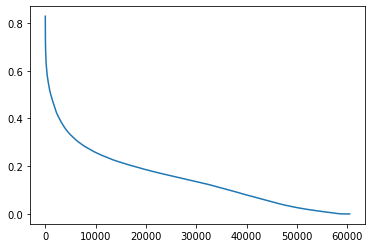

50


In [87]:
import matplotlib.pyplot as plt

mi_values=np.load("/Users/mrita/Desktop/Work/CUP/saved_mi_values.npy")
gene_labels=np.load("/Users/mrita/Desktop/Work/CUP/gene_labels.npy")

ordered_mi_idx = np.argsort(mi_values)[::-1]

plt.plot(mi_values[ordered_mi_idx])
plt.show()

print(np.sum(mi_values>0.7))

In [114]:
voc_size=5

messages=th.Tensor([[2,3,4,5],[2,3,1,5]])
start_token = th.Tensor(messages.size(0)*[voc_size+1]).to(int)
start_token = start_token.unsqueeze(1)
messages = th.cat((start_token,messages),dim=1)

print(messages.size())
print(messages)

torch.Size([2, 5])
tensor([[6., 2., 3., 4., 5.],
        [6., 2., 3., 1., 5.]])


In [115]:
1e-3

0.001

# Language model

In [152]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class TextGenerator(torch.nn.ModuleList):

    def __init__(self, batch_size,hidden_dim, max_len, vocab_size,window):
        super(TextGenerator, self).__init__()
    
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.input_size = vocab_size
        self.num_classes = vocab_size
        self.sequence_len = window
    
        # Dropout
        self.dropout = nn.Dropout(0.25)
    
        # Embedding layer
        self.embedding = nn.Embedding(self.input_size, self.hidden_dim, padding_idx=0)
    
        # Bi-LSTM
        # Forward and backward
        self.lstm_cell_forward = nn.LSTMCell(self.hidden_dim, self.hidden_dim)
        self.lstm_cell_backward = nn.LSTMCell(self.hidden_dim, self.hidden_dim)
    
        # LSTM layer
        self.lstm_cell = nn.LSTMCell(self.hidden_dim * 2, self.hidden_dim * 2)
    
        # Linear layer
        self.linear = nn.Linear(self.hidden_dim * 2, self.num_classes)
        
        
    def forward(self, x):
    
        # Bi-LSTM
        # hs = [batch_size x hidden_size]
        # cs = [batch_size x hidden_size]
        hs_forward = torch.zeros(x.size(0), self.hidden_dim)
        cs_forward = torch.zeros(x.size(0), self.hidden_dim)
        hs_backward = torch.zeros(x.size(0), self.hidden_dim)
        cs_backward = torch.zeros(x.size(0), self.hidden_dim)

        # LSTM
        # hs = [batch_size x (hidden_size * 2)]
        # cs = [batch_size x (hidden_size * 2)]
        hs_lstm = torch.zeros(x.size(0), self.hidden_dim * 2)
        cs_lstm = torch.zeros(x.size(0), self.hidden_dim * 2)

        # Weights initialization
        torch.nn.init.kaiming_normal_(hs_forward)
        torch.nn.init.kaiming_normal_(cs_forward)
        torch.nn.init.kaiming_normal_(hs_backward)
        torch.nn.init.kaiming_normal_(cs_backward)
        torch.nn.init.kaiming_normal_(hs_lstm)
        torch.nn.init.kaiming_normal_(cs_lstm)

        # From idx to embedding
        out = self.embedding(x)

        # Prepare the shape for LSTM Cells
        out = out.view(self.sequence_len, x.size(0), -1)

        forward = []
        backward = []

        # Unfolding Bi-LSTM
        # Forward
        for i in range(self.sequence_len):
            hs_forward, cs_forward = self.lstm_cell_forward(out[i], (hs_forward, cs_forward))
            hs_forward = self.dropout(hs_forward)
            cs_forward = self.dropout(cs_forward)
            forward.append(hs_forward)

         # Backward
        for i in reversed(range(self.sequence_len)):
            hs_backward, cs_backward = self.lstm_cell_backward(out[i], (hs_backward, cs_backward))
            hs_backward = self.dropout(hs_backward)
            cs_backward = self.dropout(cs_backward)
            backward.append(hs_backward)

         # LSTM
        for fwd, bwd in zip(forward, backward):
            input_tensor = torch.cat((fwd, bwd), 1)
            hs_lstm, cs_lstm = self.lstm_cell(input_tensor, (hs_lstm, cs_lstm))

         # Last hidden state is passed through a linear layer
        out = self.linear(hs_lstm)

        return out

In [207]:
def train(model,sequences,num_epochs,batch_size,hidden_dim,max_len,vocab_size,lr):
    
    # Optimizer initialization
    optimizer = optim.RMSprop(model.parameters(), lr=lr)
  
    # Defining number of batches
    num_batches = int(len(sequences) / batch_size)
  
    # Set model in training mode
    model.train()
  
    # Training pahse
    for epoch in range(num_epochs):
    
        # Mini batches
        for i in range(num_batches):
      
            # Batch definition
            try:
                x_batch = sequences[i * batch_size : (i + 1) * batch_size]
                y_batch = targets[i * batch_size : (i + 1) * batch_size]
            except:
                x_batch = sequences[i * batch_size :]
                y_batch = targets[i * batch_size :]
        
            # Convert numpy array into torch tensors
            x = torch.from_numpy(x_batch).type(torch.LongTensor)
            y = torch.from_numpy(y_batch).type(torch.LongTensor)

            # Feed the model
            y_pred = model(x)

            # Loss calculation
            loss = F.cross_entropy(y_pred, y.squeeze())

            # Clean gradients
            optimizer.zero_grad()

            # Calculate gradientes
            loss.backward()

            # Updated parameters
            optimizer.step()
      
            print("Epoch: %d ,  loss: %.5f " % (epoch, loss.item()))
        
        
def generator(model, sequences, n_chars,window):
  
    # Set the model in evalulation mode
    model.eval()
  
    # Define the softmax function
    softmax = nn.Softmax(dim=1)
  
    # Randomly is selected the index from the set of sequences
    #start = np.random.randint(0, len(sequences)-1)
    start=0
  
    # The pattern is defined given the random idx
    pattern = sequences[start]
  
    # By making use of the dictionaries, it is printed the pattern
    print("\nPattern: \n")
    print(''.join([str(value) for value in pattern]))
  
    # In full_prediction we will save the complete prediction
    full_prediction = pattern.copy()
  
    # The prediction starts, it is going to be predicted a given
    # number of characters
    for i in range(n_chars):
    
        # The numpy patterns is transformed into a tesor-type and reshaped
        new_pattern = torch.from_numpy(pattern).type(torch.LongTensor)
        new_pattern=new_pattern[-window:]
        new_pattern = new_pattern.view(1,-1)

        # Make a prediction given the pattern
        prediction = model(new_pattern)
        # It is applied the softmax function to the predicted tensor
        prediction = softmax(prediction)
        
        print(prediction)

        # The prediction tensor is transformed into a numpy array
        prediction = prediction.squeeze().detach().numpy()
        # It is taken the idx with the highest probability
        arg_max = np.argmax(prediction)
        
        print(arg_max)
        
        # The current pattern tensor is transformed into numpy array
        #pattern = pattern.squeeze().detach().numpy()
        # The new pattern is composed by the "old" pattern + the predicted character
        pattern = np.append(pattern, arg_max)

    # The full prediction is saved
    #full_prediction = np.append(full_prediction, arg_max)
        
    print("Prediction: \n")
    print(''.join([str(value) for value in pattern]))

In [130]:
def build_sequences(text, window):
    x = list()
    y = list()
    
    for i in range(len(text)):
        try:
            # Get window of chars from text
            # Then, transform it into its idx representation
            sequence = text[i:i+window]

            # Get word target
            # Then, transfrom it into its idx representation
            target = text[i+window]
            
            # Save sequences and targets
            x.append(sequence)
            y.append(target)
            
        except:
            pass
        
    x = np.array(x)
    y = np.array(y)
    
    return x, y

print(build_sequences(text,window))

(array([[0],
       [1],
       [2],
       [3]]), array([1, 2, 3, 4]))


In [212]:
text=[0,1,2,3,4,5,6,7,8,9,10,0,1,2,3,4,5,6,7,8,1,10]

lr=0.01
window=1
num_epochs = 50
batch_size = 2
hidden_dim = 128
max_len = 10
vocab_size = 11

model = TextGenerator(batch_size=batch_size, 
                      hidden_dim=hidden_dim, 
                      max_len=max_len,
                      window=window,
                      vocab_size=vocab_size)

sequences, targets = build_sequences(text,window)

train(model,sequences,num_epochs,batch_size,hidden_dim,max_len,vocab_size,lr)
generator(model=model, sequences=np.array([[0]]), n_chars=10,window=window)

Epoch: 0 ,  loss: 2.39767 
Epoch: 0 ,  loss: 10.60316 
Epoch: 0 ,  loss: 5.10231 
Epoch: 0 ,  loss: 3.47673 
Epoch: 0 ,  loss: 6.93773 
Epoch: 0 ,  loss: 4.45614 
Epoch: 0 ,  loss: 3.34900 
Epoch: 0 ,  loss: 3.26406 
Epoch: 0 ,  loss: 4.87956 
Epoch: 0 ,  loss: 4.26067 
Epoch: 1 ,  loss: 0.25907 
Epoch: 1 ,  loss: 1.98516 
Epoch: 1 ,  loss: 0.88202 
Epoch: 1 ,  loss: 2.21769 
Epoch: 1 ,  loss: 4.25616 
Epoch: 1 ,  loss: 2.48220 
Epoch: 1 ,  loss: 0.03494 
Epoch: 1 ,  loss: 0.05304 
Epoch: 1 ,  loss: 3.25542 
Epoch: 1 ,  loss: 1.12990 
Epoch: 2 ,  loss: 0.13827 
Epoch: 2 ,  loss: 0.01574 
Epoch: 2 ,  loss: 0.02850 
Epoch: 2 ,  loss: 0.41333 
Epoch: 2 ,  loss: 1.66975 
Epoch: 2 ,  loss: 0.12486 
Epoch: 2 ,  loss: 0.01695 
Epoch: 2 ,  loss: 0.02612 
Epoch: 2 ,  loss: 0.04868 
Epoch: 2 ,  loss: 0.54228 
Epoch: 3 ,  loss: 0.02776 
Epoch: 3 ,  loss: 0.01029 
Epoch: 3 ,  loss: 0.01657 
Epoch: 3 ,  loss: 0.02901 
Epoch: 3 ,  loss: 0.92483 
Epoch: 3 ,  loss: 0.11509 
Epoch: 3 ,  loss: 0.01012 


Epoch: 33 ,  loss: 0.00041 
Epoch: 33 ,  loss: 0.00060 
Epoch: 33 ,  loss: 0.00104 
Epoch: 33 ,  loss: 0.43595 
Epoch: 33 ,  loss: 0.00049 
Epoch: 33 ,  loss: 0.00069 
Epoch: 33 ,  loss: 0.00047 
Epoch: 33 ,  loss: 0.00041 
Epoch: 33 ,  loss: 0.34611 
Epoch: 34 ,  loss: 0.00044 
Epoch: 34 ,  loss: 0.00040 
Epoch: 34 ,  loss: 0.00056 
Epoch: 34 ,  loss: 0.00100 
Epoch: 34 ,  loss: 0.38619 
Epoch: 34 ,  loss: 0.00055 
Epoch: 34 ,  loss: 0.00048 
Epoch: 34 ,  loss: 0.00041 
Epoch: 34 ,  loss: 0.00046 
Epoch: 34 ,  loss: 0.48854 
Epoch: 35 ,  loss: 0.00030 
Epoch: 35 ,  loss: 0.00043 
Epoch: 35 ,  loss: 0.00055 
Epoch: 35 ,  loss: 0.00067 
Epoch: 35 ,  loss: 0.42145 
Epoch: 35 ,  loss: 0.00145 
Epoch: 35 ,  loss: 0.00038 
Epoch: 35 ,  loss: 0.00043 
Epoch: 35 ,  loss: 0.00036 
Epoch: 35 ,  loss: 0.37224 
Epoch: 36 ,  loss: 0.00043 
Epoch: 36 ,  loss: 0.00059 
Epoch: 36 ,  loss: 0.00048 
Epoch: 36 ,  loss: 0.00059 
Epoch: 36 ,  loss: 0.34376 
Epoch: 36 ,  loss: 0.00050 
Epoch: 36 ,  loss: 0

In [215]:
message=th.zeros(20,10,10)
voc_size=10

start_token = th.Tensor(messages.size(0) * [voc_size]).to(int).to(messages.device)
start_token = start_token.unsqueeze(1)

print(start_token)

tensor([[10],
        [10]])


In [2]:
# CUP
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


cancer_types = {'Bladder': 0,
                 'Brain': 1,
                 'Breast': 2,
                 'Cervix': 3,
                 'Colon': 4,
                 'CorpusUteri': 5,
                 'HeadandNeck': 6,
                 'Hematopoietic': 7,
                 'Kidney': 8,
                 'Liver': 9,
                 'Lung': 10,
                 'LymphNodes': 11,
                 'Ovary': 12,
                 'Pancreas': 13,
                 'Prostate': 14,
                 'Skyn': 15,
                 'Stomach': 16,
                 'ThyroidGland': 18}

In [14]:
nb_geness=[]
accuracies=[]
f1_scores=[]
precisions=[]
recalls=[]

for nb_genes in range(10,1670,20):

    cancer_labels = np.load("/Users/mrita/Desktop/Work/CUP/cancer_labels_val.npy")
    cancer_labels = [cancer_types[cancer] for cancer in cancer_labels]
    preds = np.load("/Users/mrita/Desktop/Work/CUP/y_pred/nb_genes_{}.npy".format(nb_genes))

    accuracy = np.sum(cancer_labels==preds)/len(preds)
    f1score=f1_score(cancer_labels,preds,average=None)
    precision, recall, _, _ = precision_recall_fscore_support(cancer_labels,preds)
    
    
    nb_geness.append(nb_genes)
    accuracies.append(accuracy)
    f1_scores.append(np.mean(f1score))
    precisions.append(np.mean(precision))
    recalls.append(np.mean(recall))
    
for nb_genes in range(3000,3700,50):

    cancer_labels = np.load("/Users/mrita/Desktop/Work/CUP/cancer_labels_val.npy")
    cancer_labels = [cancer_types[cancer] for cancer in cancer_labels]
    preds = np.load("/Users/mrita/Desktop/Work/CUP/y_pred/nb_genes_{}.npy".format(nb_genes))

    accuracy = np.sum(cancer_labels==preds)/len(preds)
    f1score=f1_score(cancer_labels,preds,average=None)
    precision, recall, _, _ = precision_recall_fscore_support(cancer_labels,preds)
    
    nb_geness.append(nb_genes)
    accuracies.append(accuracy)
    f1_scores.append(np.mean(f1score))
    precisions.append(np.mean(precision))
    recalls.append(np.mean(recall))

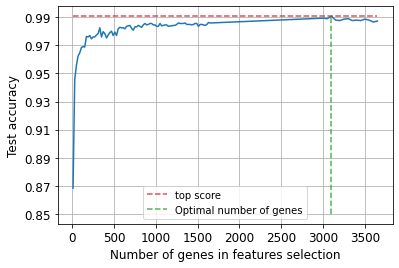

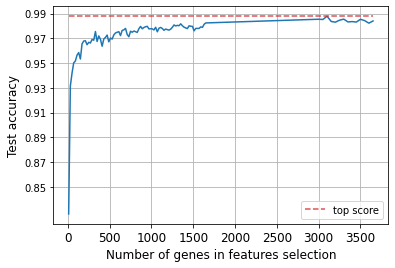

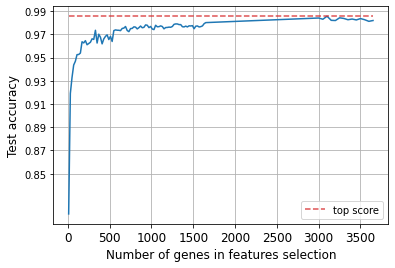

In [21]:
plt.plot(nb_geness,accuracies)
plt.plot([np.min(nb_geness),np.max(nb_geness)],[np.max(accuracies),np.max(accuracies)],
         c="tab:red",
         linestyle="--",
        alpha=0.8,
        label="top score")
plt.plot([nb_geness[np.argmax(accuracies)],nb_geness[np.argmax(accuracies)]],[0.85,np.max(accuracies)],
         c="tab:green",
         linestyle="--",
        alpha=0.8,
        label="Optimal number of genes")
plt.grid()
plt.xlabel("Number of genes in features selection",size=12)
plt.ylabel("Test accuracy",size=12)
plt.xticks(fontsize=12)
plt.yticks(np.arange(0.85, 1, 0.02),fontsize=12)
plt.legend()
plt.show()

plt.plot(nb_geness,precisions)
plt.plot([np.min(nb_geness),np.max(nb_geness)],[np.max(precisions),np.max(precisions)],
         c="tab:red",
         linestyle="--",
        alpha=0.8,
        label="top score")
plt.grid()
plt.xlabel("Number of genes in features selection",size=12)
plt.ylabel("Test accuracy",size=12)
plt.xticks(fontsize=12)
plt.yticks(np.arange(0.85, 1, 0.02),fontsize=10)
plt.legend()
plt.show()

plt.plot(nb_geness,recalls)
plt.plot([np.min(nb_geness),np.max(nb_geness)],[np.max(recalls),np.max(recalls)],
         c="tab:red",
         linestyle="--",
        alpha=0.8,
        label="top score")
plt.grid()
plt.xlabel("Number of genes in features selection",size=12)
plt.ylabel("Test accuracy",size=12)
plt.xticks(fontsize=12)
plt.yticks(np.arange(0.85, 1, 0.02),fontsize=10)
plt.legend()
plt.show()

In [11]:
from sklearn.metrics import precision_recall_fscore_support



(array([0.99      , 1.        , 0.99668874, 0.98095238, 0.98290598,
        0.9537037 , 1.        , 0.9924812 , 0.98051948, 1.        ,
        0.99692308, 0.95098039, 0.98823529, 0.94047619, 1.        ,
        0.95876289, 1.        , 1.        ]),
 array([0.97058824, 0.99418605, 0.99339934, 0.9537037 , 0.97457627,
        0.96261682, 0.96721311, 1.        , 0.99342105, 0.98969072,
        0.99082569, 0.97979798, 0.98823529, 0.9875    , 0.99173554,
        0.9893617 , 0.94791667, 1.        ]),
 array([0.98019802, 0.99708455, 0.99504132, 0.96713615, 0.9787234 ,
        0.95813953, 0.98333333, 0.99622642, 0.9869281 , 0.99481865,
        0.99386503, 0.96517413, 0.98823529, 0.96341463, 0.99585062,
        0.97382199, 0.97326203, 1.        ]),
 array([102, 172, 303, 108, 118, 107,  61, 528, 304,  97, 327,  99,  85,
         80, 121,  94,  96, 115]))